In [2]:
# https://www.tensorflow.org/api_docs/python/tf/contrib/learn/SVM
# kernels: A list of kernels for the SVM. Currently, no kernels are supported. 
# Reserved for future use for non-linear SVMs.

import tensorflow as tf
from scipy.io import loadmat

matfile = loadmat('ex6data2.mat')

def input_fn():
    return {
        'example_id': tf.constant([str(_) for _ in range(len(matfile['X']))]),
        'feature': tf.constant(matfile['X']),
    }, tf.constant(matfile['y'])

feature = tf.contrib.layers.real_valued_column('feature')

svm_classifier = tf.contrib.learn.SVM(feature_columns=[feature], 
                                      example_id_column='example_id',
                                      l1_regularization=0.0,
                                      l2_regularization=0.0)

svm_classifier.fit(input_fn=input_fn, steps=1000)
metrics = svm_classifier.evaluate(input_fn=input_fn, steps=1)

print metrics

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': None, '_save_checkpoints_secs': 600, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_tf_random_seed': None, '_task_type': None, '_environment': 'local', '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x104a37b90>, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_num_worker_replicas': 0, '_task_id': 0, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_evaluation_master': '', '_keep_checkpoint_every_n_hours': 10000, '_master': ''}
INFO:tensorflow:Created variable linear/bias_weight:0, with device=
Instructions for updating:
Use tf.losses.hinge_loss instead. Note that the order of the predictions and labels arguments were changed.
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate sum

In [42]:
from sklearn import svm
from sklearn.cross_validation import cross_val_score
import numpy as np

features = matfile['X']
labels = np.reshape(matfile['y'], len(matfile['y']))

clf = svm.SVC(kernel='linear')
scores = cross_val_score(clf, features, labels, cv=10)
print "linear accuracy:", scores.mean()

clf = svm.SVC(kernel='rbf')
scores = cross_val_score(clf, features, labels, cv=10)
print "rbf accuracy:", scores.mean()

linear accuracy: 0.432892274793
rbf accuracy: 0.6621758888


In [44]:
# https://github.com/nfmcclure/tensorflow_cookbook/blob/master/04_Support_Vector_Machines/04_Working_with_Kernels/04_svm_kernels.ipynb

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn import datasets
from tensorflow.python.framework import ops

In [62]:
# Generate non-linear data
x_vals = matfile['X']
y_vals = np.reshape(matfile['y'], len(matfile['y']))

#(x_vals, y_vals) = datasets.make_circles(n_samples=350, factor=.5, noise=.1)
#y_vals = np.array([1 if y==1 else -1 for y in y_vals])
class1_x = [x[0] for i,x in enumerate(x_vals) if y_vals[i]==1]
class1_y = [x[1] for i,x in enumerate(x_vals) if y_vals[i]==1]
class2_x = [x[0] for i,x in enumerate(x_vals) if y_vals[i]==0]
class2_y = [x[1] for i,x in enumerate(x_vals) if y_vals[i]==0]
#print x_vals, y_vals 

#features = matfile['X']
#labels = np.reshape(matfile['y'], len(matfile['y']))
#print features, labels

In [63]:
# Declare batch size
batch_size = len(x_vals)

# Initialize placeholders
x_data = tf.placeholder(shape=[None, 2], dtype=tf.float32)
y_target = tf.placeholder(shape=[None, 1], dtype=tf.float32)
prediction_grid = tf.placeholder(shape=[None, 2], dtype=tf.float32)

# Create variables for svm
b = tf.Variable(tf.random_normal(shape=[1,batch_size]))


# Apply kernel
# Linear Kernel
# my_kernel = tf.matmul(x_data, tf.transpose(x_data))

# Gaussian (RBF) kernel
gamma = tf.constant(-50.0)
dist = tf.reduce_sum(tf.square(x_data), 1)
dist = tf.reshape(dist, [-1,1])
sq_dists = tf.add(tf.subtract(dist, tf.multiply(2., tf.matmul(x_data, tf.transpose(x_data)))), tf.transpose(dist))
my_kernel = tf.exp(tf.multiply(gamma, tf.abs(sq_dists)))

# Compute SVM Model
first_term = tf.reduce_sum(b)
b_vec_cross = tf.matmul(tf.transpose(b), b)
y_target_cross = tf.matmul(y_target, tf.transpose(y_target))
second_term = tf.reduce_sum(tf.multiply(my_kernel, tf.multiply(b_vec_cross, y_target_cross)))
loss = tf.negative(tf.subtract(first_term, second_term))

# Create Prediction Kernel
# Linear prediction kernel
# my_kernel = tf.matmul(x_data, tf.transpose(prediction_grid))

# Gaussian (RBF) prediction kernel
rA = tf.reshape(tf.reduce_sum(tf.square(x_data), 1),[-1,1])
rB = tf.reshape(tf.reduce_sum(tf.square(prediction_grid), 1),[-1,1])
pred_sq_dist = tf.add(tf.subtract(rA, tf.multiply(2., tf.matmul(x_data, tf.transpose(prediction_grid)))), tf.transpose(rB))
pred_kernel = tf.exp(tf.multiply(gamma, tf.abs(pred_sq_dist)))


prediction_output = tf.matmul(tf.multiply(tf.transpose(y_target),b), pred_kernel)
prediction = tf.sign(prediction_output-tf.reduce_mean(prediction_output))
accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.squeeze(prediction), tf.squeeze(y_target)), tf.float32))

# Declare optimizer
my_opt = tf.train.GradientDescentOptimizer(0.002)
train_step = my_opt.minimize(loss)

# Initialize variables
init = tf.global_variables_initializer()

sess = tf.Session()
sess.run(init)

#ops.reset_default_graph()



In [64]:
# Training loop
loss_vec = []
batch_accuracy = []
for i in range(1000):
    rand_index = np.random.choice(len(x_vals), size=batch_size)
    rand_x = x_vals[rand_index]
    rand_y = np.transpose([y_vals[rand_index]])
    sess.run(train_step, feed_dict={x_data: rand_x, y_target: rand_y})
    
    temp_loss = sess.run(loss, feed_dict={x_data: rand_x, y_target: rand_y})
    loss_vec.append(temp_loss)
    
    acc_temp = sess.run(accuracy, feed_dict={x_data: rand_x,
                                             y_target: rand_y,
                                             prediction_grid:rand_x})
    batch_accuracy.append(acc_temp)
    
    if (i+1)%250==0:
        print('Step #' + str(i+1))
        print('Loss = ' + str(temp_loss))

Step #250
Loss = 81.224
Step #500
Loss = 34.7424
Step #750
Loss = 0.89303
Step #1000
Loss = 2.8824


In [65]:
# Create a mesh to plot points in
x_min, x_max = x_vals[:, 0].min() - 1, x_vals[:, 0].max() + 1
y_min, y_max = x_vals[:, 1].min() - 1, x_vals[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))
grid_points = np.c_[xx.ravel(), yy.ravel()]
[grid_predictions] = sess.run(prediction, feed_dict={x_data: rand_x,
                                                   y_target: rand_y,
                                                   prediction_grid: grid_points})
grid_predictions = grid_predictions.reshape(xx.shape)

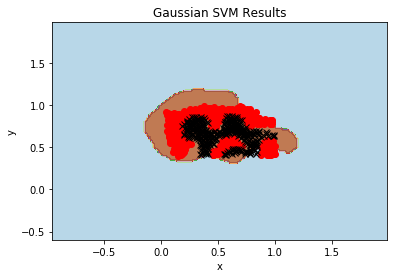

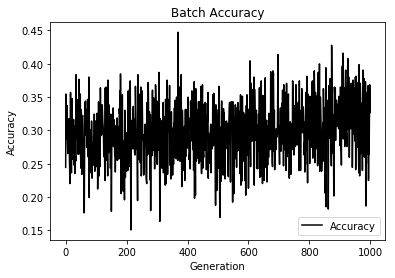

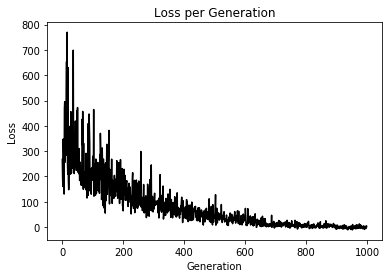

In [66]:
# Plot points and grid
plt.contourf(xx, yy, grid_predictions, cmap=plt.cm.Paired, alpha=0.8)
plt.plot(class1_x, class1_y, 'ro', label='Class 1')
plt.plot(class2_x, class2_y, 'kx', label='Class -1')
plt.title('Gaussian SVM Results')
plt.xlabel('x')
plt.ylabel('y')
#plt.legend(loc='lower right')
#plt.ylim([-1.5, 1.5])
#plt.xlim([-1.5, 1.5])
plt.show()

# Plot batch accuracy
plt.plot(batch_accuracy, 'k-', label='Accuracy')
plt.title('Batch Accuracy')
plt.xlabel('Generation')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

# Plot loss over time
plt.plot(loss_vec, 'k-')
plt.title('Loss per Generation')
plt.xlabel('Generation')
plt.ylabel('Loss')
plt.show()